***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "06"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time

import category_encoders as ce
import lightgbm as lgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

In [6]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
class RMSSE():
    def __init__(self, valid_dataframe, scales_dataframe):
        self.valid_dataframe = valid_dataframe
        self.scales_dataframe = scales_dataframe
        self.apply_inverse = False
        if set(["y_mean","y_std"]) <= set(valid_dataframe.columns):
            self.apply_inverse = True

    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        if not self.apply_inverse:  
            valid_dataframe["ypred"] = predictions
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        else:
            valid_dataframe["ypred"] = valid_dataframe["y_std"]*predictions + valid_dataframe["y_mean"]
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y_raw-ypred)**2")
        mse = valid_dataframe.groupby("sku")["sq_error"].mean().reset_index(name="mse")
        mrg = pd.merge(mse, self.scales_dataframe, how="inner", on="sku")
        return mrg.eval("sqrt(mse)/scale").mean()

    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "rmsse", metric, False

In [8]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float64)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

***
## loading data for assessment

In [9]:
if ASSESS:
    scales = pd.read_csv(f"{input_path}/scales.csv")
    skus_for_assess = pd.read_csv(f"{input_path}/skus_for_assess.csv")

    dataset = (
        pd.read_parquet(f"{input_path}/train.parquet")
        .query("sku in @skus_for_assess.sku")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    dataset

***
## model config

In [10]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.6,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    "lags": [1,],
    "window_functions":{
        "mean":   (None, [1,], [3,7,]),
        "std":    (None, [1,], [3,7]),
        "max":    (None, [1,], [3,7]),
    },
}

***
## model training: assessment

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 114.91 Mb (51.7% reduction)
Mem. usage decreased to 120.20 Mb (51.7% reduction)
Elapsed time for processing features: 0.5346522847811381 min.
[LightGBM] [Info] Total Bins 2520
[LightGBM] [Info] Number of data points in the train set: 1242194, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.814238
[100]	valid_0's rmsse: 0.76987
[150]	valid_0's rmsse: 0.765032
Early stopping, best iteration is:
[159]	valid_0's rmsse: 0.764944


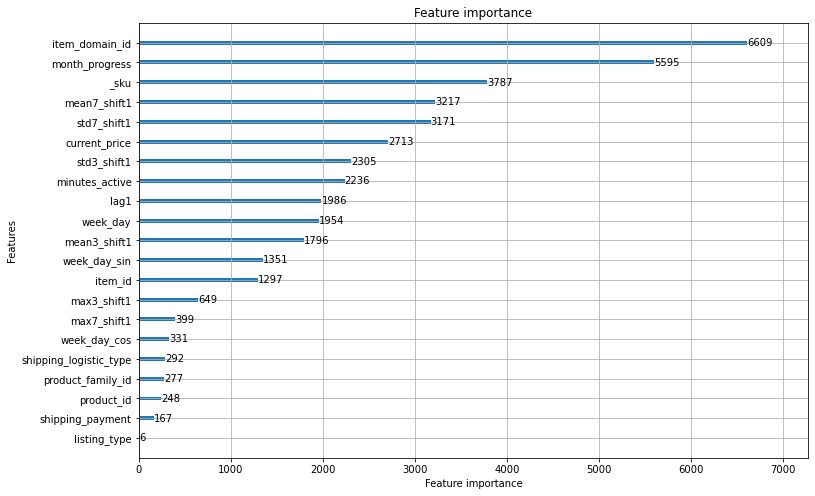

Elapsed time for training the model: 0.970982551574707 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 672.64 Mb (51.7% reduction)
Mem. usage decreased to 700.67 Mb (51.7% reduction)
Elapsed time for processing features: 4.076895864804586 min.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 7271333, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.858357
[100]	valid_0's rmsse: 0.808318
[150]	valid_0's rmsse: 0.801358
[200]	valid_0's rmsse: 0.801144
Early stopping, best iteration is:
[184]	valid_0's rmsse: 0.80097


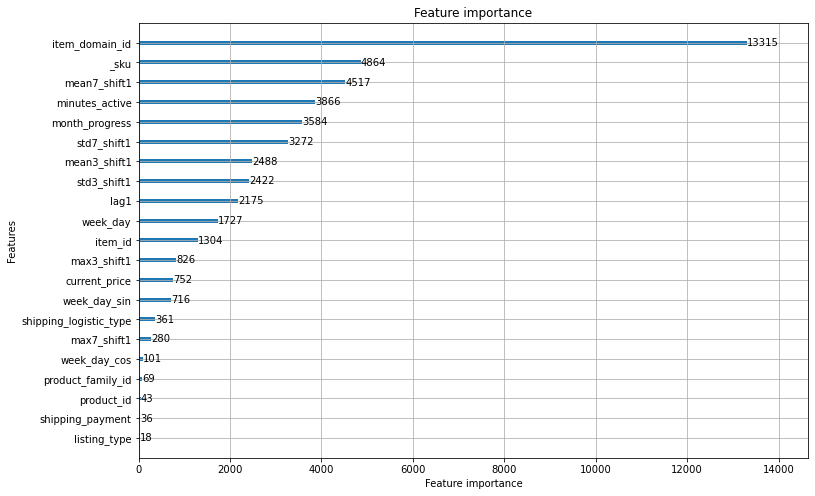

Elapsed time for training the model: 5.423467953999837 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 533.03 Mb (51.7% reduction)
Mem. usage decreased to 557.84 Mb (51.7% reduction)
Elapsed time for processing features: 2.910685622692108 min.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 5762054, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.813094
[100]	valid_0's rmsse: 0.762904
[150]	valid_0's rmsse: 0.756046
[200]	valid_0's rmsse: 0.755978
Early stopping, best iteration is:
[185]	valid_0's rmsse: 0.755617


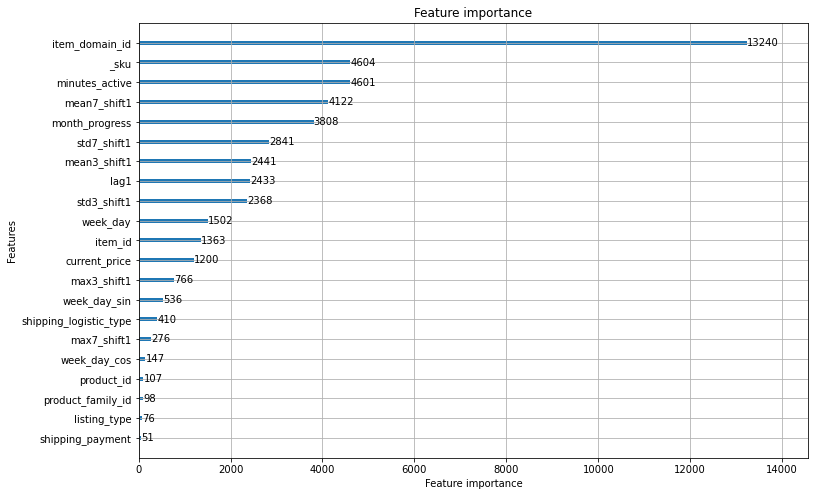

Elapsed time for training the model: 3.418465038140615 min.


{'rmsse_MLA': 0.7649440632943657,
 'rmsse_MLB': 0.8009704877223649,
 'rmsse_MLM': 0.7556167686618244,
 'rmsse_AVG': 0.773843773226185}

In [11]:
if ASSESS:
    models_by_site = list()
    sites = ["MLA","MLB","MLM"]

    for site in sites:
        print("-"*90)
        print(f"Preparing model for site: {site}")

        tic = time.time()
        train_data = dataset.query("site_id == @site").reset_index(drop=True)
        valid_idx = train_data.query("ds > '2021-03-01'").index

        model = LightGBMForecaster(**model_kwargs)
        model.prepare_features(train_data, valid_idx)
        model.train_features = reduce_mem_usage(model.train_features, verbose=True)
        model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
        gc.collect()
        tac = time.time()
        print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

        tic = time.time()
        evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
        model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
        lgb.plot_importance(model.model.model, figsize=(12,8))
        plt.show()
        models_by_site.append(model)
        tac = time.time()
        print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    errors = list()
    sites = ["MLA","MLB","MLM"]
    for site,model in zip(sites,models_by_site):
        error = model.model.model.best_score["valid_0"]["rmsse"]
        errors.append(error)
    result = {
        "rmsse_MLA":errors[0], 
        "rmsse_MLB":errors[1],
        "rmsse_MLM":errors[2],
        "rmsse_AVG":np.mean(errors),
    }
    display(result)

In [12]:
%%time
if ASSESS:
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        preds = model.predict(dataset.query("site_id==@site & ds<='2021-03-01'"))
        all_preds.append(preds)
    train_preds = pd.concat(all_preds, axis=0, ignore_index=True)

CPU times: user 10min 42s, sys: 25.5 s, total: 11min 8s
Wall time: 2min


In [13]:
if ASSESS:
    train_preds = pd.merge(train_preds, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    train_preds["sq_error"] = train_preds.eval("(y-y_pred)**2")
    train_errors = np.sqrt(train_preds.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    train_errors = pd.merge(train_errors, scales, how="inner", on="sku")
    train_errors["rmsse"] = train_errors.eval("rmse/scale")
    display(train_errors.groupby("site_id")["rmsse"].mean())
    train_errors = train_errors.set_index("sku")

site_id
MLA    0.669849
MLB    0.683040
MLM    0.709442
Name: rmsse, dtype: float64

In [14]:
%%time
if ASSESS:
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        print("Preds for site:", site)
        preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"), recursive=True)
        all_preds.append(preds)
    oof = pd.concat(all_preds, axis=0, ignore_index=True)

Preds for site: MLA
Preds for site: MLB
Preds for site: MLM
CPU times: user 18min 25s, sys: 1min, total: 19min 25s
Wall time: 34min 7s


In [15]:
if ASSESS:
    mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
    valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
    valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
    valid_errors.groupby("site_id")["rmsse"].mean()

In [16]:
if ASSESS:
    train_errors.to_csv(f"{results_path}/train_errors_lgbm-m1.csv", index=False)
    oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)

In [17]:
class InventoryDaysPredictor():

    def __init__(self, train, train_errors):
        self.train = train.copy(deep=True)
        self.train_errors = train_errors.copy(deep=True)

    def fit(self, preds):
        parameters = self.train.groupby('sku').agg({'y':['mean', 'std']}).y
        # replace nan means by overall mean
        idx = parameters[parameters["mean"].isna()].index
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        # replace zero means by overall mean
        idx = parameters[parameters["mean"] == 0].index
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        
        # replace nan stds by overall std
        idx = parameters[parameters["std"].isna()].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        # replace nan stds by overall std
        idx = parameters[parameters["std"] == 0].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        
        self.parameters = parameters.to_dict()

        predictors = dict()
        days = np.arange(1,31)
        for sku,df in tqdm(preds.groupby("sku")):
            cumpred = df.y_pred.values.cumsum()
            interp = interpolate.interp1d(cumpred, days, bounds_error=False, fill_value=(-np.inf,np.inf))
            predictors[sku] = interp
        self.predictors = predictors

    def predict(self, sku, stock):
        mean = self.parameters['mean'][sku]
        std = self.parameters['std'][sku]
        days_to_stockout = float(np.clip(self.predictors[sku](stock), a_min=1, a_max=30))
        std_days = std/mean
        return days_to_stockout,std_days

    def predict_proba(self, sku, stock, dist_kwargs, lambda1, lambda2):
        days_to_stockout,std_days = self.predict(sku, stock)
        scale = std_days * (lambda1*(days_to_stockout**lambda2))
        days = np.arange(1,31)
        probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, **dist_kwargs)
        #if prob is zero, replace with uniform
        if np.sum(probs) == 0: return np.ones(30) / 30
        return probs/np.sum(probs)

***
## Assessment of invetory days prediction

In [50]:
# tuning of correction factor
valid = pd.read_csv(f"{input_path}/validation_seed2.csv")

rmse_values = list()
mean_ae_values = list()
median_ae_values = list()

for factor in np.arange(1.0, 2.0, 0.01):
    _oof = oof.copy(deep=True)
    _oof["y_pred"] = _oof.y_pred * factor
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"), train_errors)
    predictor.fit(_oof)
    
    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
    preds = pd.DataFrame(preds, columns=["days_to_stockout"])
    
    rmse = np.sqrt(np.mean((preds.days_to_stockout - valid.inventory_days)**2))
    mean_ae = np.mean(np.abs(preds.days_to_stockout - valid.inventory_days))
    median_ae = np.median(np.abs(preds.days_to_stockout - valid.inventory_days))
    
    rmse_values.append(rmse)
    mean_ae_values.append(mean_ae)
    median_ae_values.append(median_ae)
    
    print(f"factor={factor:4f} - rmse={rmse:4f} - mean_ae={mean_ae:4f} - median_ae={median_ae:4f}")

100%|██████████| 496797/496797 [01:33<00:00, 5334.72it/s]


factor=1.000000 - rmse=10.371666 - mean_ae=7.740839 - median_ae=5.739831


100%|██████████| 496797/496797 [00:59<00:00, 8348.32it/s]


factor=1.010000 - rmse=10.340678 - mean_ae=7.713199 - median_ae=5.705992


100%|██████████| 496797/496797 [00:58<00:00, 8439.15it/s]


factor=1.020000 - rmse=10.310279 - mean_ae=7.686165 - median_ae=5.670315


100%|██████████| 496797/496797 [00:58<00:00, 8513.38it/s]


factor=1.030000 - rmse=10.280484 - mean_ae=7.659867 - median_ae=5.637325


100%|██████████| 496797/496797 [00:58<00:00, 8544.53it/s]


factor=1.040000 - rmse=10.251659 - mean_ae=7.634526 - median_ae=5.602251


100%|██████████| 496797/496797 [00:58<00:00, 8508.93it/s]


factor=1.050000 - rmse=10.223683 - mean_ae=7.610028 - median_ae=5.574518


100%|██████████| 496797/496797 [00:58<00:00, 8532.31it/s]


factor=1.060000 - rmse=10.196315 - mean_ae=7.586166 - median_ae=5.546364


100%|██████████| 496797/496797 [00:58<00:00, 8544.69it/s]


factor=1.070000 - rmse=10.169917 - mean_ae=7.563270 - median_ae=5.524561


100%|██████████| 496797/496797 [00:59<00:00, 8409.79it/s]


factor=1.080000 - rmse=10.144099 - mean_ae=7.540896 - median_ae=5.498439


100%|██████████| 496797/496797 [00:57<00:00, 8592.89it/s]


factor=1.090000 - rmse=10.119245 - mean_ae=7.519572 - median_ae=5.474101


100%|██████████| 496797/496797 [00:58<00:00, 8536.49it/s]


factor=1.100000 - rmse=10.094932 - mean_ae=7.499015 - median_ae=5.455388


100%|██████████| 496797/496797 [00:58<00:00, 8533.24it/s]


factor=1.110000 - rmse=10.071006 - mean_ae=7.478860 - median_ae=5.434159


100%|██████████| 496797/496797 [00:58<00:00, 8504.78it/s]


factor=1.120000 - rmse=10.048045 - mean_ae=7.459624 - median_ae=5.417142


100%|██████████| 496797/496797 [00:58<00:00, 8522.12it/s]


factor=1.130000 - rmse=10.026127 - mean_ae=7.441233 - median_ae=5.398094


100%|██████████| 496797/496797 [00:58<00:00, 8554.36it/s]


factor=1.140000 - rmse=10.004817 - mean_ae=7.423473 - median_ae=5.378226


100%|██████████| 496797/496797 [00:57<00:00, 8590.46it/s]


factor=1.150000 - rmse=9.984134 - mean_ae=7.406383 - median_ae=5.363808


100%|██████████| 496797/496797 [00:58<00:00, 8448.87it/s]


factor=1.160000 - rmse=9.963881 - mean_ae=7.389900 - median_ae=5.353092


100%|██████████| 496797/496797 [00:58<00:00, 8561.91it/s]


factor=1.170000 - rmse=9.944260 - mean_ae=7.374061 - median_ae=5.333911


100%|██████████| 496797/496797 [00:58<00:00, 8559.12it/s]


factor=1.180000 - rmse=9.925085 - mean_ae=7.358862 - median_ae=5.319926


100%|██████████| 496797/496797 [00:57<00:00, 8587.55it/s]


factor=1.190000 - rmse=9.906361 - mean_ae=7.344181 - median_ae=5.307703


100%|██████████| 496797/496797 [00:57<00:00, 8568.00it/s]


factor=1.200000 - rmse=9.887981 - mean_ae=7.329982 - median_ae=5.298197


100%|██████████| 496797/496797 [00:57<00:00, 8570.18it/s]


factor=1.210000 - rmse=9.870182 - mean_ae=7.316341 - median_ae=5.287142


100%|██████████| 496797/496797 [00:57<00:00, 8625.99it/s]


factor=1.220000 - rmse=9.852915 - mean_ae=7.303394 - median_ae=5.278087


100%|██████████| 496797/496797 [00:57<00:00, 8581.26it/s]


factor=1.230000 - rmse=9.836238 - mean_ae=7.291026 - median_ae=5.267425


100%|██████████| 496797/496797 [00:58<00:00, 8518.50it/s]


factor=1.240000 - rmse=9.820166 - mean_ae=7.279275 - median_ae=5.257576


100%|██████████| 496797/496797 [00:59<00:00, 8339.63it/s]


factor=1.250000 - rmse=9.804584 - mean_ae=7.267891 - median_ae=5.249164


100%|██████████| 496797/496797 [00:58<00:00, 8560.55it/s]


factor=1.260000 - rmse=9.789666 - mean_ae=7.257061 - median_ae=5.241527


100%|██████████| 496797/496797 [00:58<00:00, 8527.33it/s]


factor=1.270000 - rmse=9.775232 - mean_ae=7.246722 - median_ae=5.233925


100%|██████████| 496797/496797 [00:56<00:00, 8732.49it/s]


factor=1.280000 - rmse=9.761507 - mean_ae=7.237044 - median_ae=5.235107


100%|██████████| 496797/496797 [00:58<00:00, 8530.30it/s]


factor=1.290000 - rmse=9.748306 - mean_ae=7.227909 - median_ae=5.227356


100%|██████████| 496797/496797 [00:58<00:00, 8537.58it/s]


factor=1.300000 - rmse=9.735591 - mean_ae=7.219323 - median_ae=5.225294


100%|██████████| 496797/496797 [00:58<00:00, 8552.37it/s]


factor=1.310000 - rmse=9.723152 - mean_ae=7.211084 - median_ae=5.216856


100%|██████████| 496797/496797 [00:58<00:00, 8543.21it/s]


factor=1.320000 - rmse=9.711343 - mean_ae=7.203393 - median_ae=5.215037


100%|██████████| 496797/496797 [00:58<00:00, 8558.20it/s]


factor=1.330000 - rmse=9.700043 - mean_ae=7.196126 - median_ae=5.216437


100%|██████████| 496797/496797 [00:58<00:00, 8507.82it/s]


factor=1.340000 - rmse=9.689055 - mean_ae=7.189207 - median_ae=5.213321


100%|██████████| 496797/496797 [00:57<00:00, 8596.44it/s]


factor=1.350000 - rmse=9.678670 - mean_ae=7.182756 - median_ae=5.213571


100%|██████████| 496797/496797 [00:57<00:00, 8583.09it/s]


factor=1.360000 - rmse=9.668666 - mean_ae=7.176663 - median_ae=5.213167


100%|██████████| 496797/496797 [00:58<00:00, 8525.75it/s]


factor=1.370000 - rmse=9.659352 - mean_ae=7.171212 - median_ae=5.214590


100%|██████████| 496797/496797 [00:57<00:00, 8614.63it/s]


factor=1.380000 - rmse=9.650396 - mean_ae=7.166162 - median_ae=5.214898


100%|██████████| 496797/496797 [00:57<00:00, 8582.60it/s]


factor=1.390000 - rmse=9.641944 - mean_ae=7.161688 - median_ae=5.218672


100%|██████████| 496797/496797 [00:58<00:00, 8517.92it/s]


factor=1.400000 - rmse=9.634000 - mean_ae=7.157730 - median_ae=5.221164


100%|██████████| 496797/496797 [00:58<00:00, 8456.51it/s]


factor=1.410000 - rmse=9.626363 - mean_ae=7.154043 - median_ae=5.218699


100%|██████████| 496797/496797 [00:58<00:00, 8552.97it/s]


factor=1.420000 - rmse=9.619170 - mean_ae=7.150767 - median_ae=5.223073


100%|██████████| 496797/496797 [00:58<00:00, 8539.55it/s]


factor=1.430000 - rmse=9.612439 - mean_ae=7.147939 - median_ae=5.226452


100%|██████████| 496797/496797 [00:58<00:00, 8545.23it/s]


factor=1.440000 - rmse=9.605941 - mean_ae=7.145336 - median_ae=5.229190


100%|██████████| 496797/496797 [00:58<00:00, 8525.04it/s]


factor=1.450000 - rmse=9.599726 - mean_ae=7.142871 - median_ae=5.234877


100%|██████████| 496797/496797 [00:58<00:00, 8530.07it/s]


factor=1.460000 - rmse=9.593656 - mean_ae=7.140737 - median_ae=5.240711


100%|██████████| 496797/496797 [00:58<00:00, 8443.19it/s]


factor=1.470000 - rmse=9.587931 - mean_ae=7.138750 - median_ae=5.245023


100%|██████████| 496797/496797 [00:58<00:00, 8554.87it/s]


factor=1.480000 - rmse=9.582616 - mean_ae=7.136984 - median_ae=5.250755


100%|██████████| 496797/496797 [00:58<00:00, 8533.30it/s]


factor=1.490000 - rmse=9.577807 - mean_ae=7.135650 - median_ae=5.253321


100%|██████████| 496797/496797 [00:58<00:00, 8500.05it/s]


factor=1.500000 - rmse=9.573166 - mean_ae=7.134491 - median_ae=5.256765


100%|██████████| 496797/496797 [00:57<00:00, 8575.62it/s]


factor=1.510000 - rmse=9.568986 - mean_ae=7.133764 - median_ae=5.262909


100%|██████████| 496797/496797 [00:58<00:00, 8464.21it/s]


factor=1.520000 - rmse=9.565042 - mean_ae=7.133272 - median_ae=5.268323


100%|██████████| 496797/496797 [00:58<00:00, 8549.92it/s]


factor=1.530000 - rmse=9.561405 - mean_ae=7.133051 - median_ae=5.277337


100%|██████████| 496797/496797 [00:56<00:00, 8747.63it/s]


factor=1.540000 - rmse=9.558109 - mean_ae=7.133121 - median_ae=5.284644


100%|██████████| 496797/496797 [00:58<00:00, 8525.56it/s]


factor=1.550000 - rmse=9.555091 - mean_ae=7.133407 - median_ae=5.295007


100%|██████████| 496797/496797 [00:58<00:00, 8518.93it/s]


factor=1.560000 - rmse=9.552531 - mean_ae=7.134159 - median_ae=5.302497


100%|██████████| 496797/496797 [00:57<00:00, 8576.57it/s]


factor=1.570000 - rmse=9.550229 - mean_ae=7.135082 - median_ae=5.310839


100%|██████████| 496797/496797 [00:58<00:00, 8560.58it/s]


factor=1.580000 - rmse=9.548318 - mean_ae=7.136266 - median_ae=5.320027


100%|██████████| 496797/496797 [00:57<00:00, 8571.87it/s]


factor=1.590000 - rmse=9.546702 - mean_ae=7.137797 - median_ae=5.326739


100%|██████████| 496797/496797 [00:57<00:00, 8573.92it/s]


factor=1.600000 - rmse=9.545380 - mean_ae=7.139574 - median_ae=5.332869


100%|██████████| 496797/496797 [00:57<00:00, 8592.64it/s]


factor=1.610000 - rmse=9.544248 - mean_ae=7.141522 - median_ae=5.340713


100%|██████████| 496797/496797 [00:57<00:00, 8575.93it/s]


factor=1.620000 - rmse=9.543379 - mean_ae=7.143716 - median_ae=5.348128


100%|██████████| 496797/496797 [00:58<00:00, 8519.00it/s]


factor=1.630000 - rmse=9.542854 - mean_ae=7.146207 - median_ae=5.357346


100%|██████████| 496797/496797 [00:58<00:00, 8559.57it/s]


factor=1.640000 - rmse=9.542604 - mean_ae=7.148940 - median_ae=5.365289


100%|██████████| 496797/496797 [00:58<00:00, 8508.01it/s]


factor=1.650000 - rmse=9.542478 - mean_ae=7.151771 - median_ae=5.375051


100%|██████████| 496797/496797 [00:57<00:00, 8584.89it/s]


factor=1.660000 - rmse=9.542460 - mean_ae=7.154709 - median_ae=5.383961


100%|██████████| 496797/496797 [00:58<00:00, 8518.76it/s]


factor=1.670000 - rmse=9.542704 - mean_ae=7.157966 - median_ae=5.389240


100%|██████████| 496797/496797 [00:58<00:00, 8500.97it/s]


factor=1.680000 - rmse=9.543176 - mean_ae=7.161542 - median_ae=5.398052


100%|██████████| 496797/496797 [00:58<00:00, 8544.49it/s]


factor=1.690000 - rmse=9.543745 - mean_ae=7.165205 - median_ae=5.408692


100%|██████████| 496797/496797 [00:58<00:00, 8557.60it/s]


factor=1.700000 - rmse=9.544446 - mean_ae=7.168897 - median_ae=5.417574


100%|██████████| 496797/496797 [00:58<00:00, 8558.88it/s]


factor=1.710000 - rmse=9.545286 - mean_ae=7.172626 - median_ae=5.426563


100%|██████████| 496797/496797 [00:58<00:00, 8530.31it/s]


factor=1.720000 - rmse=9.546485 - mean_ae=7.176595 - median_ae=5.435274


100%|██████████| 496797/496797 [00:58<00:00, 8545.39it/s]


factor=1.730000 - rmse=9.547707 - mean_ae=7.180641 - median_ae=5.449343


100%|██████████| 496797/496797 [00:57<00:00, 8571.06it/s]


factor=1.740000 - rmse=9.549137 - mean_ae=7.184809 - median_ae=5.458131


100%|██████████| 496797/496797 [00:57<00:00, 8598.20it/s]


factor=1.750000 - rmse=9.550776 - mean_ae=7.189177 - median_ae=5.469486


100%|██████████| 496797/496797 [00:57<00:00, 8567.04it/s]


factor=1.760000 - rmse=9.552555 - mean_ae=7.193655 - median_ae=5.480058


100%|██████████| 496797/496797 [00:59<00:00, 8343.99it/s]


factor=1.770000 - rmse=9.554676 - mean_ae=7.198444 - median_ae=5.490543


100%|██████████| 496797/496797 [00:58<00:00, 8461.34it/s]


factor=1.780000 - rmse=9.557031 - mean_ae=7.203405 - median_ae=5.500335


100%|██████████| 496797/496797 [00:58<00:00, 8507.13it/s]


factor=1.790000 - rmse=9.559499 - mean_ae=7.208486 - median_ae=5.512316


100%|██████████| 496797/496797 [00:59<00:00, 8389.06it/s]


factor=1.800000 - rmse=9.562103 - mean_ae=7.213624 - median_ae=5.522555


100%|██████████| 496797/496797 [00:58<00:00, 8504.95it/s]


factor=1.810000 - rmse=9.564926 - mean_ae=7.218939 - median_ae=5.532808


100%|██████████| 496797/496797 [00:57<00:00, 8566.64it/s]


factor=1.820000 - rmse=9.567829 - mean_ae=7.224249 - median_ae=5.544036


100%|██████████| 496797/496797 [00:58<00:00, 8546.83it/s]


factor=1.830000 - rmse=9.570841 - mean_ae=7.229677 - median_ae=5.553100


100%|██████████| 496797/496797 [00:58<00:00, 8499.84it/s]


factor=1.840000 - rmse=9.574123 - mean_ae=7.235368 - median_ae=5.564503


100%|██████████| 496797/496797 [00:57<00:00, 8577.03it/s]


factor=1.850000 - rmse=9.577632 - mean_ae=7.241270 - median_ae=5.575581


100%|██████████| 496797/496797 [00:58<00:00, 8498.27it/s]


factor=1.860000 - rmse=9.581354 - mean_ae=7.247331 - median_ae=5.587714


100%|██████████| 496797/496797 [00:57<00:00, 8588.91it/s]


factor=1.870000 - rmse=9.585304 - mean_ae=7.253487 - median_ae=5.598647


100%|██████████| 496797/496797 [00:58<00:00, 8543.59it/s]


factor=1.880000 - rmse=9.589536 - mean_ae=7.259907 - median_ae=5.609146


100%|██████████| 496797/496797 [00:59<00:00, 8419.13it/s]


factor=1.890000 - rmse=9.593910 - mean_ae=7.266413 - median_ae=5.620380


100%|██████████| 496797/496797 [00:58<00:00, 8516.55it/s]


factor=1.900000 - rmse=9.598404 - mean_ae=7.273040 - median_ae=5.631660


100%|██████████| 496797/496797 [00:58<00:00, 8558.46it/s]


factor=1.910000 - rmse=9.602917 - mean_ae=7.279633 - median_ae=5.642683


100%|██████████| 496797/496797 [00:57<00:00, 8574.10it/s]


factor=1.920000 - rmse=9.607560 - mean_ae=7.286315 - median_ae=5.653028


100%|██████████| 496797/496797 [00:57<00:00, 8579.28it/s]


factor=1.930000 - rmse=9.612248 - mean_ae=7.293032 - median_ae=5.664767


100%|██████████| 496797/496797 [00:58<00:00, 8528.79it/s]


factor=1.940000 - rmse=9.617122 - mean_ae=7.299918 - median_ae=5.676501


100%|██████████| 496797/496797 [00:58<00:00, 8507.53it/s]


factor=1.950000 - rmse=9.622127 - mean_ae=7.306917 - median_ae=5.689033


100%|██████████| 496797/496797 [00:58<00:00, 8561.55it/s]


factor=1.960000 - rmse=9.627162 - mean_ae=7.313811 - median_ae=5.698076


100%|██████████| 496797/496797 [00:57<00:00, 8647.70it/s]


factor=1.970000 - rmse=9.632341 - mean_ae=7.320753 - median_ae=5.711672


100%|██████████| 496797/496797 [00:57<00:00, 8579.30it/s]


factor=1.980000 - rmse=9.637573 - mean_ae=7.327765 - median_ae=5.723073


100%|██████████| 496797/496797 [00:58<00:00, 8542.82it/s]


factor=1.990000 - rmse=9.642937 - mean_ae=7.334842 - median_ae=5.735373


In [56]:
factor_results = pd.DataFrame({
    "factor":np.arange(1.0, 2.0, 0.01),
    "rmse":rmse_values,
    "mean_ae":mean_ae_values,
    "median_ae":median_ae_values,
})
factor_results.sort_values("median_ae", ascending=True)

,factor,rmse,mean_ae,median_ae
36,1.36,9.668666,7.176663,5.213167
34,1.34,9.689055,7.189207,5.213321
35,1.35,9.678670,7.182756,5.213571
37,1.37,9.659352,7.171212,5.214590
38,1.38,9.650396,7.166162,5.214898
...,...,...,...,...
1,1.01,10.340678,7.713199,5.705992
97,1.97,9.632341,7.320753,5.711672
98,1.98,9.637573,7.327765,5.723073
99,1.99,9.642937,7.334842,5.735373


In [58]:
corr_factor = 1.36

_oof = oof.copy(deep=True)
_oof["y_pred"] = corr_factor * _oof["y_pred"]

if ASSESS:
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"), train_errors)
    predictor.fit(_oof)

100%|██████████| 496797/496797 [01:14<00:00, 6629.88it/s]


In [59]:
if ASSESS:
    valid = pd.read_csv(f"{input_path}/validation_seed2.csv")

    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
    preds = pd.DataFrame(preds, columns=["days_to_stockout"])

100%|██████████| 496797/496797 [01:10<00:00, 7035.78it/s]


RMSE (mean):  9.668665701537396
RMSE (median):  5.213167262921997
MAE (mean):  7.176662979479659
MAE (median):  5.213167262921997


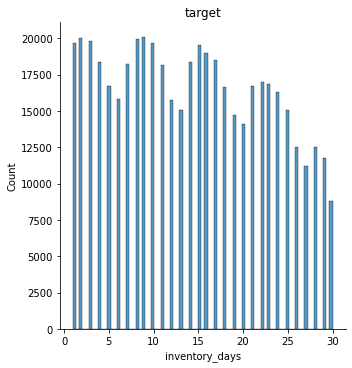

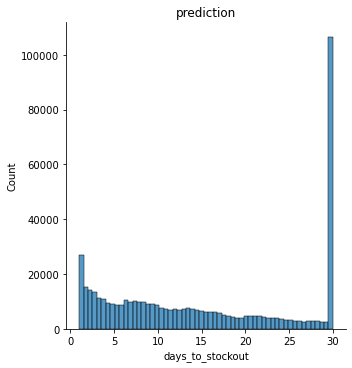

In [60]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(np.mean((preds.days_to_stockout - valid.inventory_days)**2)) )
    print("MAE (mean): ", np.mean(np.abs(preds.days_to_stockout - valid.inventory_days)))
    print("MAE (median): ", np.median(np.abs(preds.days_to_stockout - valid.inventory_days)))

    sns.displot(valid.inventory_days)
    plt.title("target")
    plt.show()

    sns.displot(preds.days_to_stockout)
    plt.title("prediction")
    plt.show()

***
## Assessment of RPS

In [61]:
beta = 0.634505
lambda1 = 0.458712
lambda2 = 0.967726

In [62]:
if ASSESS:
    valid_files = [fn for fn in glob(f"{input_path}/validation_seed*.csv") if "seed2.csv" not in fn]
    results = list()

    for files in valid_files:
        valid = pd.read_csv(files)

        preds_proba = list()
        for sku,df in tqdm(valid.groupby("sku")):
            preds_proba.append(predictor.predict_proba(
                sku, 
                stock=df.target_stock.values[0],
                dist_kwargs={"beta":beta},
                lambda1=lambda1, 
                lambda2=lambda2,
            ))
        preds_proba = np.array(preds_proba)

        rps = scoring_function(valid.inventory_days.values, preds_proba)
        results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
        print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 496797/496797 [03:17<00:00, 2510.33it/s]


{'file': 'validation_seed19', 'rps': 3.9236427827378653}


100%|██████████| 496797/496797 [03:06<00:00, 2658.57it/s]


{'file': 'validation_seed23', 'rps': 3.9262706663405074}


100%|██████████| 496797/496797 [03:30<00:00, 2358.60it/s]


{'file': 'validation_seed17', 'rps': 3.927440318344293}


In [63]:
if ASSESS:
    display(pd.DataFrame(results))
    
    # cleanup ram
    del models_by_site
    gc.collect()

,file,rps
0,validation_seed19,3.923643
1,validation_seed23,3.926271
2,validation_seed17,3.927440


***
## model training

In [80]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")

dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

nrows: 36.594396
nskus: 635633


In [81]:
test = (
    pd.read_parquet(f"{input_path}/test.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

nrows: 15.78567
nskus: 526189


------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 292.71 Mb (51.7% reduction)
Elapsed time for processing features: 2.200952235857646 min.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 3164181, number of used features: 21


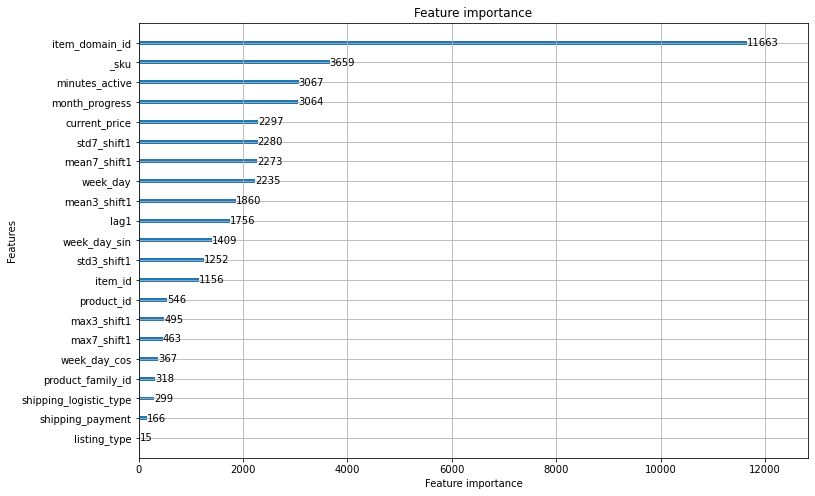

Elapsed time for training the model: 0.8428151686986287 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 1764.36 Mb (50.7% reduction)
Elapsed time for processing features: 10.254694553216298 min.
[LightGBM] [Info] Total Bins 3163
[LightGBM] [Info] Number of data points in the train set: 18687512, number of used features: 21


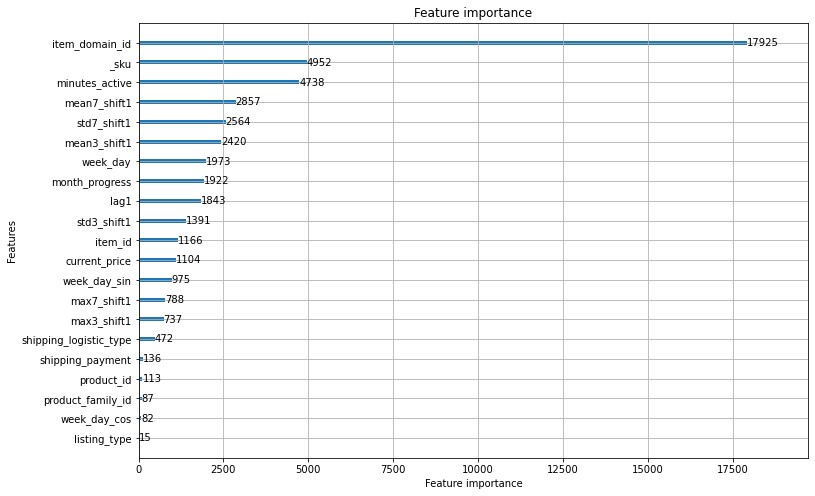

Elapsed time for training the model: 6.5100945353508 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 1363.79 Mb (51.7% reduction)
Elapsed time for processing features: 9.456755550702413 min.
[LightGBM] [Info] Total Bins 3044
[LightGBM] [Info] Number of data points in the train set: 14742703, number of used features: 21


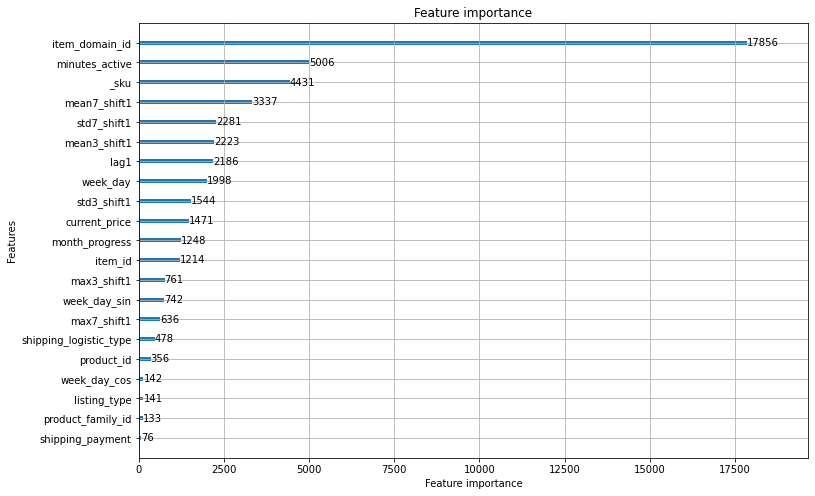

Elapsed time for training the model: 4.409682218233744 min.


In [66]:
models_by_site = list()
sites = [
    "MLA",
    "MLB",
    "MLM",
]
num_iterations = {
    "MLA": 160,
    "MLB": 190,
    "MLM": 190,
}

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    
    _model_kwargs = dict(model_kwargs)
    _model_kwargs["model_params"]["num_iterations"] = num_iterations[site]

    model = LightGBMForecaster(**_model_kwargs)
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit()
    lgb.plot_importance(model.model.model, figsize=(12,8))
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [68]:
preds_by_site = list()

for site,model in tqdm(zip(sites,models_by_site)):
    preds = model.predict(test.query("site_id == @site"), recursive=True)
    preds_by_site.append(preds)

3it [1:12:19, 1446.53s/it]


In [82]:
predictions = pd.concat(preds_by_site, ignore_index=True)
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}.csv", index=False)

print(corr_factor)
predictions["y_pred"] = corr_factor * predictions["y_pred"]
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}-corr.csv", index=False)

1.36


In [83]:
# todo: fix train_errors
predictor = InventoryDaysPredictor(dataset, train_errors)
predictor.fit(predictions)

100%|██████████| 526189/526189 [01:51<00:00, 4729.89it/s]


100%|██████████| 526189/526189 [01:49<00:00, 4789.98it/s]


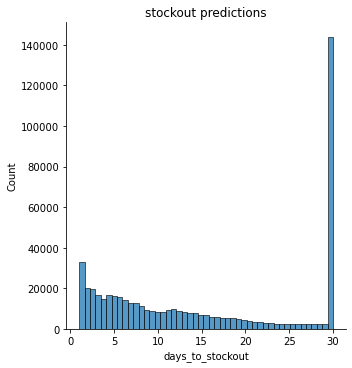

In [84]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])

sns.displot(stockout_preds.days_to_stockout)
plt.title("stockout predictions")
plt.show()

0.634505 0.458712 0.967726


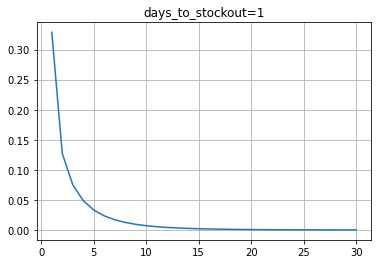

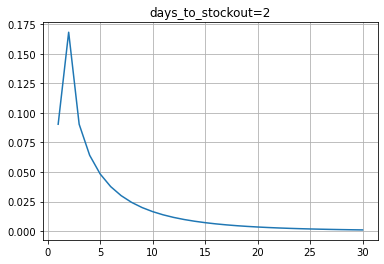

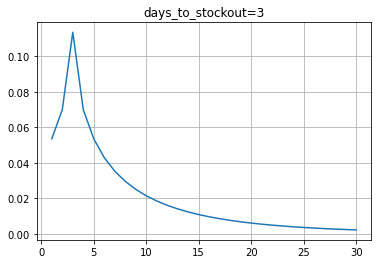

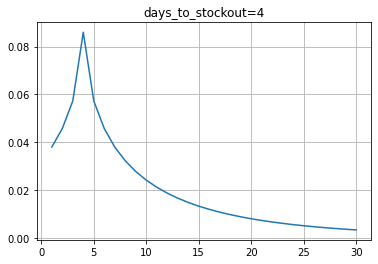

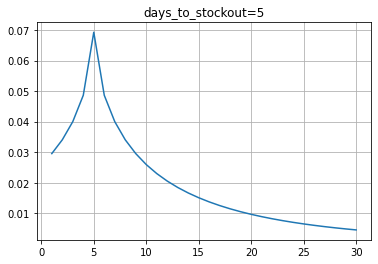

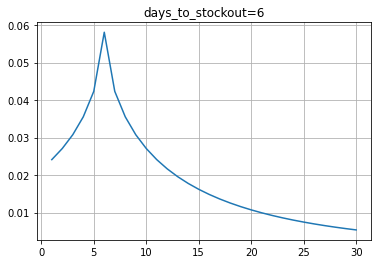

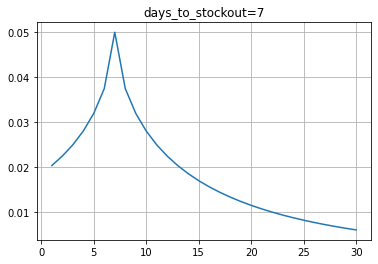

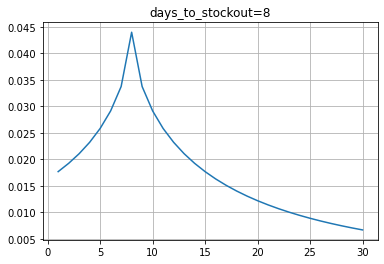

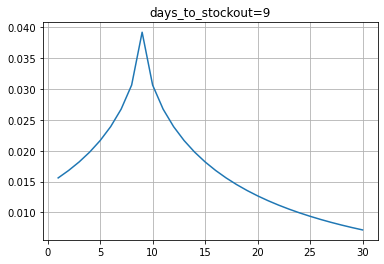

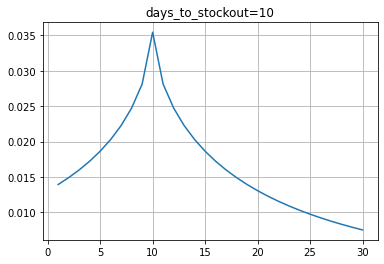

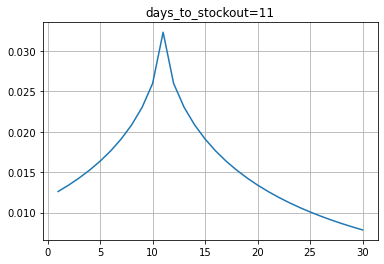

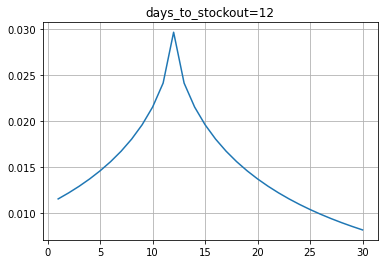

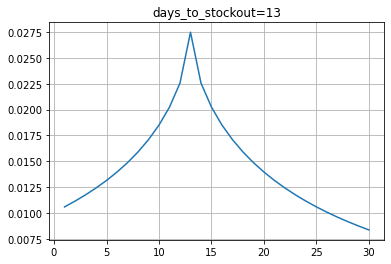

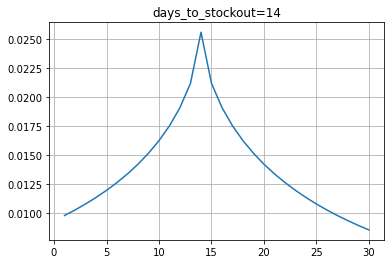

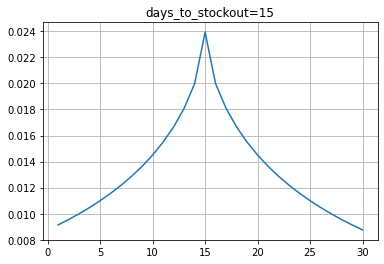

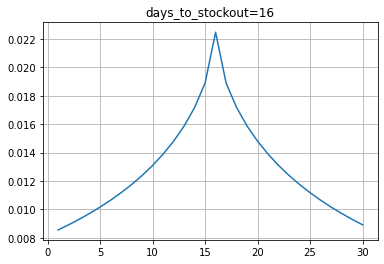

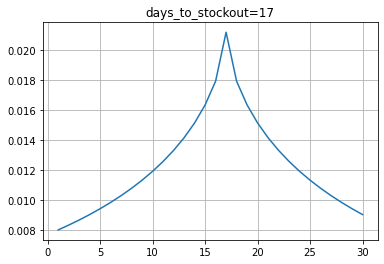

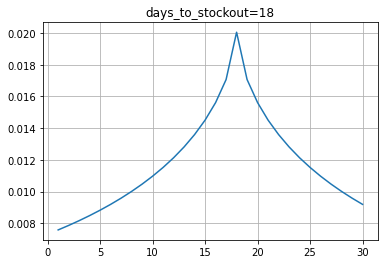

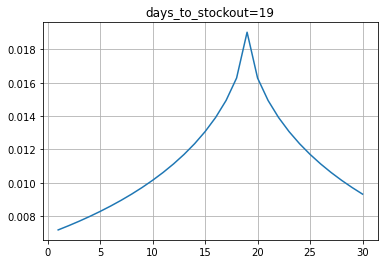

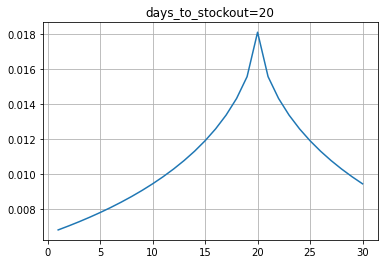

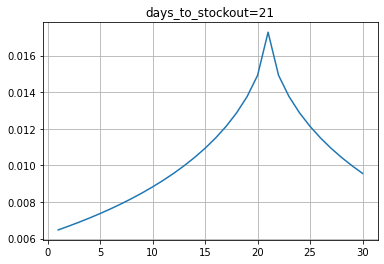

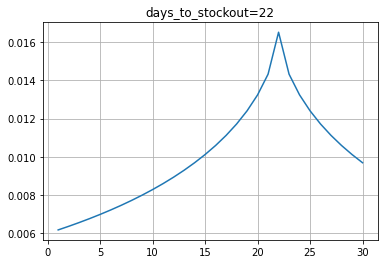

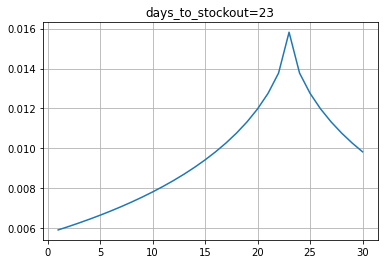

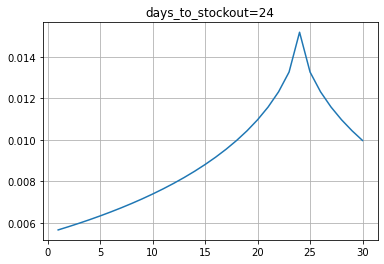

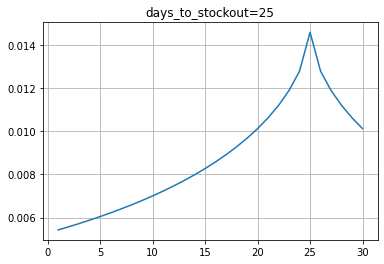

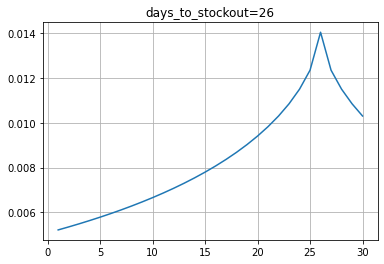

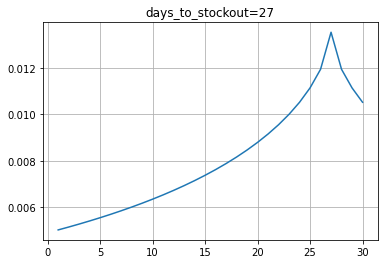

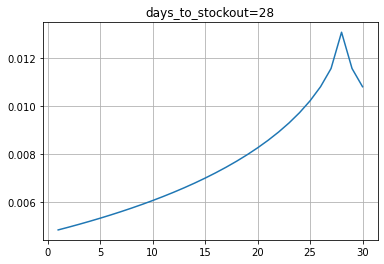

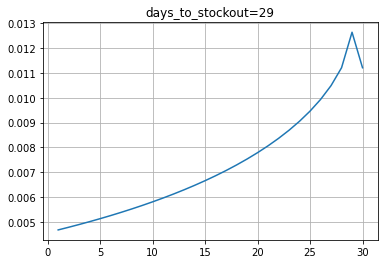

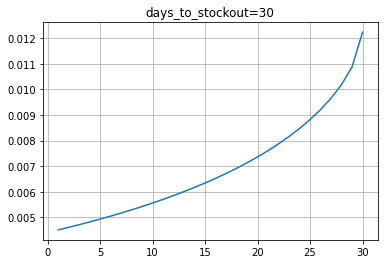

In [85]:
print(beta, lambda1, lambda2)
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (lambda1*(days_to_stockout**lambda2))
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [86]:
skus = list()
preds_proba = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    skus.append(sku)
    preds_proba.append(predictor.predict_proba(
        sku, 
        stock=df.target_stock.values[0],
        dist_kwargs={"beta":beta},
        lambda1=lambda1, 
        lambda2=lambda2,
    ))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=skus)

100%|██████████| 526189/526189 [04:24<00:00, 1986.40it/s]


In [87]:
unpreds_proba = np.ones((len(unpredictable),30)) / 30
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.072302,0.088433,0.121695,0.091312,0.074122,0.062493,0.053778,0.046907,0.041318,0.036674,0.032753,0.029400,0.026506,0.023986,0.021778,0.019830,0.018104,0.016567,0.015194,0.013961,0.012852,0.011851,0.010944,0.010122,0.009374,0.008692,0.008070,0.007501,0.006979,0.006500
1,0.020942,0.021442,0.021961,0.022500,0.023060,0.023643,0.024249,0.024882,0.025542,0.026231,0.026952,0.027708,0.028501,0.029335,0.030213,0.031140,0.032122,0.033163,0.034273,0.035459,0.036732,0.038107,0.039602,0.041241,0.043057,0.045102,0.047458,0.050274,0.053916,0.061192
2,0.025573,0.025934,0.026305,0.026686,0.027078,0.027482,0.027898,0.028328,0.028771,0.029229,0.029704,0.030195,0.030705,0.031235,0.031786,0.032362,0.032963,0.033593,0.034256,0.034954,0.035694,0.036481,0.037323,0.038232,0.039222,0.040317,0.041554,0.043000,0.044822,0.048319
3,0.026144,0.027611,0.029221,0.031001,0.032985,0.035220,0.037772,0.040744,0.044306,0.048800,0.055179,0.058053,0.050474,0.045563,0.041764,0.038634,0.035966,0.033642,0.031587,0.029748,0.028089,0.026581,0.025202,0.023935,0.022766,0.021684,0.020678,0.019741,0.018866,0.018047
5,0.019964,0.020640,0.021352,0.022105,0.022900,0.023744,0.024641,0.025597,0.026619,0.027714,0.028894,0.030171,0.031560,0.033082,0.034764,0.036645,0.038781,0.041262,0.044254,0.048141,0.054904,0.048946,0.044827,0.041723,0.039170,0.036984,0.035065,0.033352,0.031805,0.030395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393191,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
262125,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393209,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
131068,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


***
## generate submission

In [88]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [89]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [90]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***